# Radial Basis Functions

Radial Basis Function Networks are a simpler, modified version of Multi Layer Perceptrons with the following modifications:
* The network only has three layers, an input, a hidden and an output layer
* The input layer has neurons equal to the dimensionality of the training data. Since we're playing around with points in the 2D Cartesian plane as inputs, our input layer will only have two neurons 
* The major difference lies in the hidden layer. Though this layer may contain any number of neurons, these have to use a _radial_ activation function (and hence the name RBF Networks). We'll be using the gaussian radial basis function which has the following form $$ \phi(z) = e^{-z^2 / 2 \sigma^2 } $$ where $z = ||x - c_j||$. $x$ is the input and $c_j$ is the _center_ of the RBF neuron. $\sigma$ is a hyperparameter.
* For classification problems like ours, the output layer, as usual, is typically equal to the number of classes.
* The general notion of weights and biases is redefined here. RBF Nets generally don't have weights from the input to the hidden layer, and typically don't have a bias term.

There are a variety of different ways to train an RBF Network, but typically we only train the weights from the hidden layer to the output layer. Other parameters like the _centres_ of the RBF neurons and $\beta$s are trained in a separate manner. In this tutorial, we only plan to learn the weights of the RBF Network. One should also note that gradient descent is not the most obvious choice for training RBF Nets, so resources on the topic might be scarce.

* For a more complete understanding of RBF Networks, see http://mccormickml.com/2013/08/15/radial-basis-function-network-rbfn-tutorial/
* If you prefer slides, refer to http://home.iitk.ac.in/~lbehera/Files/Lecture5_RBFN.pdf
* To know more about the different ways to train an RBF Net, see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.109.312&rep=rep1&type=pdf

In [21]:
%%bash
# To split a class across multiple cells
pip install jdc

In [22]:
# Library imports
import random
import numpy as np
import jdc
from datasets import *
# For some handy helper functions
import sklearn

We continue using the Network class similar to the assignment on Multi Layer Perceptrons

**Note, again:** We are using jdc to define each method of `class Network` in seperate cells. jdc follows the following syntax,

```py
%%add_to #CLASS_NAME#
def dummy_method(self):
```

In [23]:
class Network(object):

    def __init__(self, sizes, training_data):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network. For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron."""
        # Told you, an RBF Net only has three layers.
        assert len(sizes) == 3
        self.num_layers = 3
        self.sizes = sizes
        # Similar to an MLP, we initialize the trainable parameters randomly
        # Recall that RBFs don't typically have a bias term
        self.initialize_weights()
        self.initialize_centers(training_data)
        self.initialize_sigmas(training_data)

# Initialization

## 3.3.1 Initialize weights, centres and sigmas

The weights for the network are initialized randomly from a Gaussian distribution with mean 0, and variance 1, and so are the sigmas. Note that we only have weights between the hidden and output layers. The centres, however, are randomly selected out of the training points. Implement the following function to initialize weights and centres.

![image.png](https://chrisjmccormick.files.wordpress.com/2013/08/architecture_simple2.png)

In [24]:
%%add_to Network
def initialize_weights(self):
    # YOUR CODE HERE


In [25]:
%%add_to Network
def initialize_centers(self, training_data):
    # YOUR CODE HERE


In [26]:
%%add_to Network
def initialize_sigmas(self, training_data):
    # YOUR CODE HERE


# Training

We shall implement backpropogration with stocastic mini-batch gradient descent to optimize out network.

In [27]:
%%add_to Network
def train(self, training_data, epochs, mini_batch_size, learning_rate):
    """Train the neural network using gradient descent.  
    The ``training_data`` is a list of tuples
    ``(x, y)`` representing the training inputs and the desired
    outputs.  The other parameters are self-explanatory."""

    # training_data is a list and is passed by reference
    # To prevernt affecting the original data we use 
    # this hack to create a copy of training_data     
    training_data = list(training_data)
    
    for i in range(epochs):
        # Get mini-batches    
        mini_batches = self.create_mini_batches(training_data, mini_batch_size)
        
        # Itterate over mini-batches to update pramaters   
        cost = sum(map(lambda mini_batch: self.update_params(mini_batch, learning_rate), mini_batches))
        
        # Find accuracy of the model at the end of epoch         
        acc = self.evaluate(training_data)
        
        print("Epoch {} complete. Total cost: {}, Accuracy: {}".format(i, cost, acc))

## 3.1.2 Create mini-batches

Split the training data into mini-batches of size `mini_batch_size` and return a list of mini-batches.

In [28]:
%%add_to Network
def create_mini_batches(self, training_data, mini_batch_size):
    # Shuffling data helps a lot in mini-batch SDG
    random.shuffle(training_data)
    # YOUR CODE HERE
    
    return mini_batches

## 3.1.3 Update weights and centres
 The update rules for centres and weights respectively, are:

$$ c_{j} (t+1) = c_{j} (t) - \eta \frac{\partial E}{\partial c_{j}} $$
$$ w_{i} (t+1) = w_{i} (t) - \eta \frac{\partial E}{\partial w_{i}} $$

This time we'll use the cross entropy loss function $$ L = - \log (\frac{e^{f_{y_i}}}{\sum_j e^{f_j}}) $$ where $f_{y_i}$ is the probability of the correct class. These probabilities are in turn calculated by passing the values of the output layer through the softmax function $$f_j(z) = \frac{e^{z_j}}{\sum_i e^{z_i}}$$

To reiterate, the output of the last layer is simply $y = \sum_{i=1}^{h} \phi_i w_i $ where  $\phi_i$ is the radial basis function being used. $ \phi_i = e^{-z_i^2 / 2 \sigma^2} $ where $z_i = || x - c_i|| $ is the Euclidian distance between $x$ and $c_i$ and $\sigma$ is the width of the center.

In [29]:
%%add_to Network
def update_params(self, mini_batch, learning_rate):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation."""
    
    # Initialize gradients
    delta_w = np.zeros(self.weights.shape)
    delta_c = np.zeros(self.centers.shape)
    delta_s = np.zeros(self.sigmas.shape)
    
    total_cost = 0
    
    for x, y in mini_batch:
        # Obtain the mean squered error and the gradeinets
        # with resepect to trainable parameters        
        cost, del_w, del_c, del_s = self.backprop(x, y)
        
        # Add the gradients for each sample in mini-batch
        delta_w = delta_w + del_w
        delta_c = delta_c + del_c
        delta_s = delta_s + del_s
        total_cost += cost

    # Update self.centres, self.weights and self.sigmas
    # using delta_c, delta_w, delta_s and learning_rate
    self.centers = self.centers - (learning_rate / len(mini_batch)) * delta_c
    self.weights = self.weights - (learning_rate / len(mini_batch)) * delta_w
    self.sigmas = self.sigmas - (learning_rate / len(mini_batch)) * delta_s
    
    return total_cost

In [30]:
%%add_to Network
def backprop(self, x, y):
    """Return arry containiing cost, del_b, del_w representing the
    cost function C(x) and gradient for cost function.  ``del_b`` and
    ``del_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    # Forward pass
    ys, yd, phi = self.forward(x)
    
    # Backward pass     
    cost, del_w, del_c, del_s = self.backward(x, ys, yd, phi, y)

    return cost, del_w, del_c, del_s

## 3.1.5 Loss Functions
Implement the softmax function, cross entropy loss, and its derivative

In [44]:
%%add_to Network
def softmax(self, scores):
    """The softmax function."""
    # YOUR CODE HERE


In [48]:
%%add_to Network
def cross_entropy_loss(self, probs, y):
    """Cross entropy loss."""
    # YOUR CODE HERE


In [35]:
%%add_to Network
def softmax_cross_entropy_derivative(self, scores, y):
    """Derivative of the cross entropy loss function w.r.t raw scores."""
    # YOUR CODE HERE


## 3.1.6 Implement forward propogration


In [36]:
%%add_to Network
def forward(self, x):
    """Compute the outputs of the hidden and output layer.
    Also compute the class probabilities using softmax."""
    # YOUR CODE HERE

    # phi is the output of the hidden layer
    # yd is the output of the output layer
    # ys is the class probabilities computed using softmax
    return ys, yd, phi

## 3.1.8 Implement backward pass

Refer [this](http://colah.github.io/posts/2015-08-Backprop/) blog by Christopher Olah to understand how gradient commpuation happens during backward pass.

In [39]:
%%add_to Network
def backward(self, x, ys, yd, phi, y):
    """Compute and return cost funcation, gradients for 
    weights and biases for each layer."""
    # Initialize gradient arrays
    del_c = np.zeros(self.centers.shape)
    del_w = np.zeros(self.weights.shape)

    # Compute for last layer
    
    cost = self.cross_entropy_loss(ys, y)
    
    # YOUR CODE HERE
    delta = 

    del_w = 
    del_c = 
    del_s = 
    return cost, del_w, del_c, del_s

In [40]:
%%add_to Network
def evaluate(self, test_data):
    """Return the accuracy of Network. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    test_results = [(np.argmax(self.forward(x)[0]), np.argmax(y))
                    for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results) * 100 / len(test_results)

# Showtime

Let's test our implementation on a bunch of datasets.

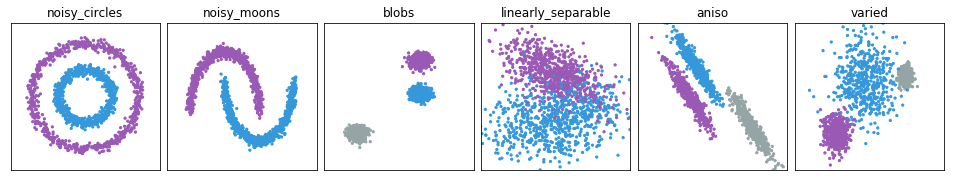

In [41]:
datasets = generate_datsets()

plot_datasets(datasets)

In [42]:
def pre_process_data(x, y):
    # Find number samples     
    n = len(y)
    # Find number classes
    c  = max(y) + 1
    
    # Normalize the input
    x = sklearn.preprocessing.scale(x)
    
    x = np.split(x, n)
    x = [a.squeeze() for a in x]
    
    # Convert lables to one-hot vectors     
    one_hot = np.zeros([n, c])
    one_hot[range(n), y] = 1
    
    y = np.split(one_hot, n)
    y = [a.reshape(-1, 1) for a in y]
    
    return list(zip(x, y))

## 3.1.9 Try out different hyper-parameters

In [49]:
datasets_with_pred = {}

for name, dataset in datasets.items():
    
    print("Training dataset: {}".format(name))

    X, Y = dataset

    # Find number classes
    c  = max(Y) + 1
    
    # Pre-process the data
    # Checkout the implementation for some cool numpy tricks     
    training_data = pre_process_data(X, Y)

    network = Network([2, 15, c], training_data)
    
    network.train(training_data, 50, 100, 5)
    
    predictions = list(map(lambda sample: np.argmax(network.forward(sample[0])[0]), training_data))
    
    datasets_with_pred[name] = X, Y, predictions

Training dataset: noisy_circles
Epoch 0 complete. Total cost: 1123.962432709939, Accuracy: 49.333333333333336
Epoch 1 complete. Total cost: 1039.7152538128578, Accuracy: 47.46666666666667
Epoch 2 complete. Total cost: 1039.7189490929545, Accuracy: 46.93333333333333
Epoch 3 complete. Total cost: 1039.7199122325028, Accuracy: 46.86666666666667
Epoch 4 complete. Total cost: 1039.7202203625993, Accuracy: 46.733333333333334
Epoch 5 complete. Total cost: 1039.720382857188, Accuracy: 46.46666666666667
Epoch 6 complete. Total cost: 1039.7204773978513, Accuracy: 45.13333333333333
Epoch 7 complete. Total cost: 1039.720543418544, Accuracy: 44.666666666666664
Epoch 8 complete. Total cost: 1039.720584306975, Accuracy: 44.2
Epoch 9 complete. Total cost: 1039.7206152020399, Accuracy: 43.46666666666667
Epoch 10 complete. Total cost: 1039.7206385300406, Accuracy: 42.93333333333333
Epoch 11 complete. Total cost: 1039.7206556270992, Accuracy: 42.733333333333334
Epoch 12 complete. Total cost: 1039.7206705

Epoch 10 complete. Total cost: 1647.8978172770735, Accuracy: 69.26666666666667
Epoch 11 complete. Total cost: 1647.900253242004, Accuracy: 69.2
Epoch 12 complete. Total cost: 1647.9022114095615, Accuracy: 69.33333333333333
Epoch 13 complete. Total cost: 1647.9038293089588, Accuracy: 69.4
Epoch 14 complete. Total cost: 1647.9051816509186, Accuracy: 69.53333333333333
Epoch 15 complete. Total cost: 1647.9063275611818, Accuracy: 69.33333333333333
Epoch 16 complete. Total cost: 1647.9073086444782, Accuracy: 69.33333333333333
Epoch 17 complete. Total cost: 1647.9081528454963, Accuracy: 69.46666666666667
Epoch 18 complete. Total cost: 1647.90889199412, Accuracy: 69.33333333333333
Epoch 19 complete. Total cost: 1647.9095452195168, Accuracy: 69.4
Epoch 20 complete. Total cost: 1647.910117892627, Accuracy: 69.46666666666667
Epoch 21 complete. Total cost: 1647.9106294278288, Accuracy: 69.53333333333333
Epoch 22 complete. Total cost: 1647.911091976347, Accuracy: 69.46666666666667
Epoch 23 complete

Epoch 20 complete. Total cost: 1647.9240717321472, Accuracy: 35.46666666666667
Epoch 21 complete. Total cost: 1647.9236714129336, Accuracy: 35.46666666666667
Epoch 22 complete. Total cost: 1647.9233115953746, Accuracy: 35.53333333333333
Epoch 23 complete. Total cost: 1647.9229889841342, Accuracy: 35.53333333333333
Epoch 24 complete. Total cost: 1647.9226987890847, Accuracy: 35.6
Epoch 25 complete. Total cost: 1647.9224349762885, Accuracy: 35.6
Epoch 26 complete. Total cost: 1647.92219546796, Accuracy: 35.53333333333333
Epoch 27 complete. Total cost: 1647.9219761144307, Accuracy: 35.53333333333333
Epoch 28 complete. Total cost: 1647.9217761883685, Accuracy: 35.6
Epoch 29 complete. Total cost: 1647.9215923204197, Accuracy: 35.6
Epoch 30 complete. Total cost: 1647.921423944353, Accuracy: 35.6
Epoch 31 complete. Total cost: 1647.9212678943486, Accuracy: 35.6
Epoch 32 complete. Total cost: 1647.9211243099844, Accuracy: 35.6
Epoch 33 complete. Total cost: 1647.9209908578089, Accuracy: 35.6
E

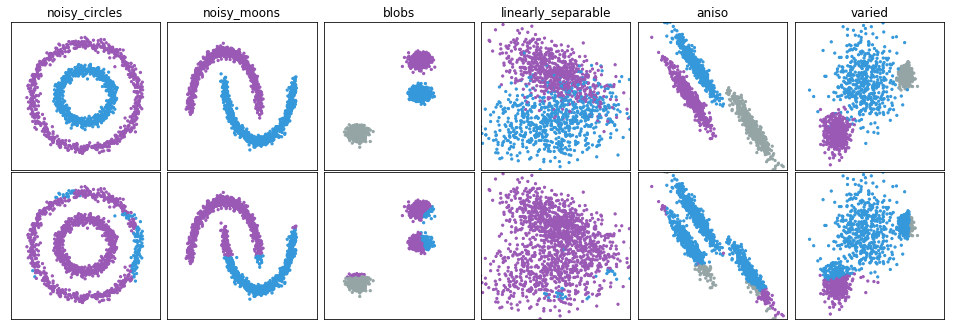

In [50]:
plot_datasets(datasets_with_pred)